In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.feature_selection import f_regression
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    print("Load Data")
data_df.head()

RANDOM_STATE = 42

In [3]:
# Define X and Y
ad_hc_df = data_df[
    data_df["Diagnosis"].isin(["AD", "HC"]) & (data_df["Harmonized"].notna())
].copy()
tbi_df = data_df[
    data_df["Diagnosis"].isin(["NEG", "POS"]) & (data_df["Harmonized"].notna())
].copy()
mci_df = data_df[
    data_df["Diagnosis"].isin(["MCI", "HC"]) & (data_df["Harmonized"].notna())
].copy()

X_ad_hc = np.vstack(ad_hc_df["EVC"].values)
X_tbi = np.vstack(tbi_df["EVC"].values)
X_mci = np.vstack(mci_df["EVC"].values)

X_mci = StandardScaler().fit_transform(X_mci)
X_tbi = StandardScaler().fit_transform(X_tbi)
X_ad_hc = StandardScaler().fit_transform(X_ad_hc)

# X_mci = MinMaxScaler().fit_transform(X_mci)
# X_tbi = MinMaxScaler().fit_transform(X_tbi)
# X_ad_hc = MinMaxScaler().fit_transform(X_ad_hc)

y_ad_hc = ad_hc_df["Diagnosis"].map({"AD": 1, "HC": 0}).values
y_tbi = tbi_df["Diagnosis"].map({"POS": 1, "NEG": 0}).values
y_mci = mci_df["Diagnosis"].map({"MCI": 1, "HC": 0}).values

In [4]:
def getCoefs(x, y):
    mdl = LogisticRegressionCV(
        solver="liblinear",
        random_state=RANDOM_STATE,
        class_weight="balanced",
        cv=LeaveOneOut(),
        n_jobs=-1,
    )
    mdl.fit(x, y)
    coefs = mdl.coef_
    coefs = -1 + 2 * ((coefs - coefs.min()) / (coefs.max() - coefs.min()))
    # coefs = MinMaxScaler(feature_range=(-1,1)).fit_transform(coefs)
    return coefs.flatten()


def calculate_r2(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    return r2_score(y, y_pred)


coefs_ad = getCoefs(X_ad_hc, y_ad_hc)
coefs_tbi = getCoefs(X_tbi, y_tbi)
#coefs_mci = getCoefs(X_mci, y_mci)
#coefs_mci = []

223	1.4737201589143578
188	1.314533534131284
13	1.2845270581138784
8	1.0526088442165276
15	0.8555332987961264
150	0.8342779450681519
53	0.8030960190876825
220	0.7930145506106444
115	0.7906365107988642
17	0.789424488266655

223	1.4737201589143578
188	1.314533534131284
13	1.2845270581138784
8	1.0526088442165276
15	0.8555332987961264
150	0.8342779450681519
53	0.8030960190876825
220	0.7930145506106444
115	0.7906365107988642
17	0.789424488266655

53	2.0
163	2.0
70	1.9781747597049575
210	1.8298680811353387
136	1.7187813086242472
51	1.709322546188028
85	1.7003170223136048
151	1.6433727789199617
150	1.6417734005428883
6	1.5865021060634104



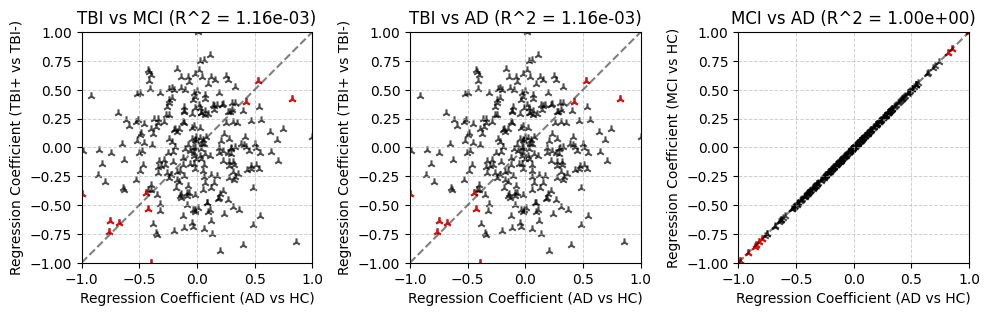

In [5]:
def highlightInformative(x, y, axis):
    residuals = np.abs(y - x)
    magnitudes = np.abs(x) + np.abs(y)
    weights = -1 * residuals + magnitudes
    top_10_indices = np.argsort(weights)[-10:][::-1]
    axis.scatter(x[top_10_indices], y[top_10_indices], alpha=0.9, c="red", marker="2")
    for idx in top_10_indices:
        print(f"{idx}\t{weights[idx]}")
    print("==========\n")

coefs_mci = coefs_ad

fig, axes = plt.subplots(1, 3, figsize=(10, 12))

r2_tbi_mci = calculate_r2(coefs_mci, coefs_tbi)
axes[0].scatter(coefs_mci, coefs_tbi, alpha=0.7, c="black", marker="2")
axes[0].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
axes[0].set_xlabel("Regression Coefficient (AD vs HC)")
axes[0].set_ylabel("Regression Coefficient (TBI+ vs TBI-)")
axes[0].set_title(f"TBI vs MCI (R^2 = {r2_tbi_mci:.2e})")
axes[0].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_aspect("equal", adjustable="box")
highlightInformative(coefs_mci, coefs_tbi, axes[0])

r2_ad_hc_tbi = calculate_r2(coefs_ad, coefs_tbi)
axes[1].scatter(coefs_ad, coefs_tbi, alpha=0.7, c="black", marker="2")
axes[1].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
axes[1].set_xlabel("Regression Coefficient (AD vs HC)")
axes[1].set_ylabel("Regression Coefficient (TBI+ vs TBI-)")
axes[1].set_title(f"TBI vs AD (R^2 = {r2_ad_hc_tbi:.2e})")
axes[1].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_aspect("equal", adjustable="box")
highlightInformative(coefs_ad, coefs_tbi, axes[1])

r2_ad_hc_mci = calculate_r2(coefs_ad, coefs_mci)
axes[2].scatter(coefs_ad, coefs_mci, alpha=0.7, c="black", marker="2")
axes[2].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
axes[2].set_xlabel("Regression Coefficient (AD vs HC)")
axes[2].set_ylabel("Regression Coefficient (MCI vs HC)")
axes[2].set_title(f"MCI vs AD (R^2 = {r2_ad_hc_mci:.2e})")
axes[2].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
axes[2].set_xlim([-1, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_aspect("equal", adjustable="box")
highlightInformative(coefs_ad, coefs_mci, axes[2])

plt.tight_layout()
plt.show()

In [ ]:
# Run statistical tests and multiple comparisons corrections
# p_values_ad_hc = np.array([ttest_ind(X_ad_hc[y_ad_hc == 1, i], X_ad_hc[y_ad_hc == 0, i], equal_var=False)[1]
#                             for i in range(X_ad_hc.shape[1])])

# p_values_tbi = np.array([ttest_ind(X_tbi[y_tbi == 1, i], X_tbi[y_tbi == 0, i], equal_var=False)[1]
#                           for i in range(X_tbi.shape[1])])
f_stat_ad, p_values_ad = f_regression(X_ad_hc, y_ad_hc)
f_stat_tbi, p_values_tbi = f_regression(X_tbi, y_tbi)
f_stat_mci, p_values_mci = f_regression(X_mci, y_mci)

_, p_values_ad_hc_corrected, _, _ = multipletests(p_values_ad, method="bonferroni")
_, p_values_tbi_corrected, _, _ = multipletests(p_values_tbi, method="bonferroni")
_, p_values_mci_corrected, _, _ = multipletests(p_values_mci, method="bonferroni")

significant_ad_hc = np.where(p_values_ad_hc_corrected < 0.05)[0]
significant_tbi = np.where(p_values_tbi_corrected < 0.05)[0]
significant_mci = np.where(p_values_mci_corrected < 0.05)[0]

print(f"P Values AD/HC: {p_values_ad}", end="\n========\n\n")
print(f"P Values TBI+/TBI-: {p_values_tbi}", end="\n========\n\n")
print(f"P Values MCI/HC: {p_values_mci}", end="\n========\n\n")

P Values AD/HC: [0.72078834 0.52251149 0.72819448 0.15952658 0.87425385 0.81218723
 0.40874058 0.89614189 0.21179749 0.87214698 0.62172156 0.90733784
 0.72519144 0.83979121 0.91211325 0.92989541 0.89579218 0.69485338
 0.24113044 0.95440799 0.25904694 0.27976473 0.68674636 0.44231871
 0.07554367 0.35007296 0.42827664 0.6711386  0.0703005  0.96438109
 0.40190175 0.80114329 0.42058181 0.53406268 0.4556897  0.89152555
 0.68569784 0.71560522 0.21390758 0.27927857 0.59044794 0.64985127
 0.56865639 0.48361133 0.7905484  0.41863055 0.34542612 0.39989897
 0.78626638 0.42673579 0.43380218 0.19098389 0.47424431 0.36364537
 0.51851084 0.61902937 0.27773086 0.51404685 0.53341236 0.50060706
 0.38046255 0.6971342  0.07663699 0.57266601 0.58220987 0.64071299
 0.48030749 0.2477054  0.25238998 0.87904945 0.04702647 0.40416991
 0.95368643 0.72182922 0.31128716 0.29587251 0.16471064 0.32826608
 0.29073782 0.93447714 0.82503107 0.76478013 0.96106088 0.19893186
 0.71745405 0.00641274 0.93225012 0.69389016 0

: 